# **Quantum programming III**
$\newcommand{\bra}[1]{\langle#1|}$
$\newcommand{\ket}[1]{|#1\rangle}$

## **Practice session 3**

In this session, we are going to focus on quantum teleportation.

### **Quantum teleportation**

What is quantum teleportation? It is the notion that one can send quantum information&mdash;a quantum state&mdash;over to another party using entangled states. Let us first look at the protocol and then discuss why it is a big deal.

Suppose two agents, usually called Alice and Bob, share a two particle entangled state. Each has one particle and the total state of the two particle system is a Bell state. Suppose next that Alice has yet another particle in her possession: a single copy of a qubit in some generic state $\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$ that she does not know exactly, and she wants to transfer this (unknown) state to Bob. What does this mean, how could Alice send the state to Bob? It can mean many things. For instance: 

1. Alice might physically transport the qubit (the particle) to Bob.

2. Alice could make a copy of the qubit and physically transport the copy (the particle) to Bob.

3. Alice could find out what is the state of the qubit and send information of the *qubit state* to Bob. Bob can then prepare that state in the lab. No particle is physically transported between the parties.

The first sense is not interesting, it is not new. 

The second is also not interesting; but it turns out it is actually impossible in the quantum world. There is a fundamental theorem about quantum states: one cannot copy an arbitrary quantum state (so-called *no cloning theorem*). This is a striking result since copying a state is something we frequently rely on in the classical world. For instance, the routine statement `a = b` in a programming language where one assigns the value of `b` to `a` can mean that the value of `a` is copied over to `b`. 

The third sense is in the direction of what we would like to achieve. Alas, it fails because of the no cloning theorem. If Alice wanted to know what is the state, she would need to make many copies of the qubit, make many measurements and collect statistics to learn what the exact state is. However, even if this were the case&mdash;even if Alice had many copies of the qubit&mdash;it would not be a good idea since characterizing the state precisely requires sending a lot of classical information because the coefficients $\alpha, \beta$ take values in a continuous space.

It turns out there is a fourth way: 

4. Alice uses *quantum teleportation*. 

Alice can use the entangled states she shares with Bob to *transfer the state of the single qubit over to Bob's particle*! This is why it's called teleportation: the original state in Alice's possession is lost and Bob's particle will be in the state $\ket{\psi}$. It does involve sending two bits of classical information, but the overhead is tiny. This is a truly quantum feat; it is impossible in the classical world. Note also that: 

- no physical particles are transported from Alice to Bob,
- Alice will not know the state $\ket{\psi}$.


How does this work in detail?

#### **Preparation: create shared entangled state**

Alice and Bob need to share a two-qubit entangled state, we allocate qubits $\ket{q_2 q_1}$ for this. The unknown state $\ket{\psi}$ that Alice wants to send to Bob is the state of qubit $\ket{q_0}$. The total initial state of the system is

$$
\ket{q_2 q_1 q_0}.
$$

We assume initially $\ket{q_2 q_1} = \ket{00}$ and use our entangling circuit from the previous session to create a Bell state for Alice and Bob.

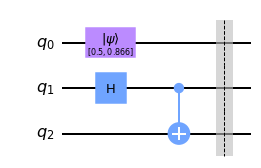

In [1]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
import numpy as np

# coefficients of uknown state Alice sends to Bob
unknown_state = [np.sqrt(1. / 4), np.sqrt(3. / 4)]

# create quantum circuit
qc = QuantumCircuit(3)

qc.initialize(unknown_state, 0)
qc.h(1)                          # entangle Alice and Bob qubits
qc.cx(1, 2)                      #

# run
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = assemble(qc)
result = sim.run(qobj).result()  # run circuit, get results

# draw the circuit
qc.draw("mpl")

#### **Teleportation: step 1**

Alice applies the CNOT gate to her two qubits, where the control is the unknown state $\ket{\psi}$ of qubit $q_0$. She then applies Hadamard to the unknown state.

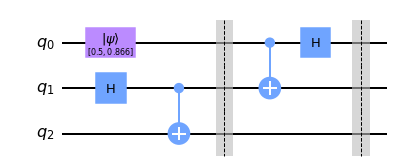

In [2]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
import numpy as np

# coefficients of uknown state Alice sends to Bob
unknown_state = [np.sqrt(1. / 4), np.sqrt(3. / 4)]

# create quantum circuit
qc = QuantumCircuit(3)

qc.initialize(unknown_state, 0)
qc.h(1)                          # entangle Alice and Bob qubits
qc.cx(1, 2)                      #

qc.barrier()

qc.cx(0, 1)                      # Alice performs ops on her qubits
qc.h(0)

# run
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = assemble(qc)
result = sim.run(qobj).result()  # run circuit, get results

# draw the circuit
qc.draw("mpl")

Note we also added a barrier after the first, entangling sub-circuit to visually separate the steps. 

#### **Teleportation: step 2**

Alice measures her two qubits, the result being a string of two bits, either $00, 01, 10$ or $11$. She then sends the bitstring to Bob.

We want to store the measurement results in classical bits. For this purpose, we need to add two classical bits to the circuit.

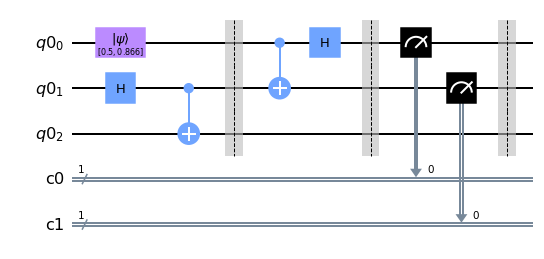

In [3]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np

# coefficients of uknown state Alice sends to Bob
unknown_state = [np.sqrt(1. / 4), np.sqrt(3. / 4)]

# create quantum circuit
q = QuantumRegister(3)

c0 = ClassicalRegister(1, name="c0")
c1 = ClassicalRegister(1, name="c1")

qc = QuantumCircuit(q, c0, c1)

qc.initialize(unknown_state, 0)

qc.h(1)                          # entangle Alice and Bob qubits
qc.cx(1, 2)                      #

qc.barrier()

qc.cx(0, 1)                      # Alice performs on her qubits
qc.h(0)

qc.barrier()

qc.measure(q[0], c0)             # Alice measures her qubits
qc.measure(q[1], c1)

# run
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = assemble(qc)
result = sim.run(qobj).result()  # run circuit, get results

# draw the circuit
qc.draw("mpl")

#### **Teleportation: step 3**

Bob receives the measurement bitstring from Alice and applies the following protocol. If the bitstring is: 

1. 00 &mdash; nothing to do.

2. 01 &mdash; apply `x()` gate to his qubit.

3. 10 &mdash; apply `z()` gate to his qubit.

4. 11 &mdash; apply `x()`, then `z()` gate to his qubit.

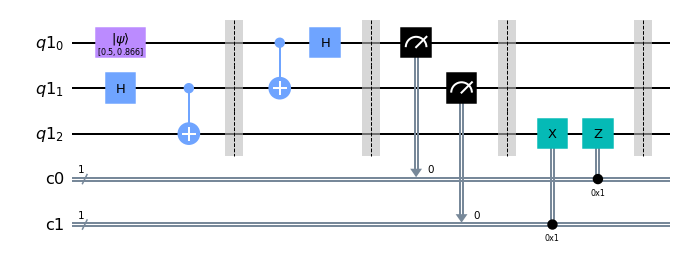

In [4]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np

# coefficients of uknown state Alice sends to Bob
unknown_state = [np.sqrt(1. / 4), np.sqrt(3. / 4)]

# create quantum circuit
q = QuantumRegister(3)

c0 = ClassicalRegister(1, name="c0")
c1 = ClassicalRegister(1, name="c1")

qc = QuantumCircuit(q, c0, c1)

qc.initialize(unknown_state, 0)

qc.h(1)                          # entangle Alice and Bob qubits
qc.cx(1, 2)                      #

qc.barrier()

qc.cx(0, 1)                      # Alice performs on her qubits
qc.h(0)

qc.barrier()

qc.measure(q[0], c0)             # Alice measures her qubits
qc.measure(q[1], c1)

qc.barrier()

# ctrl gates
qc.x(q[2]).c_if(c1, 1)
qc.z(q[2]).c_if(c0, 1)

# run
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = assemble(qc)
result = sim.run(qobj).result()  # run circuit, get results

# final state
final_state = result.get_statevector()

# draw the circuit
qc.draw("mpl")

At the end of this circuit the state of Bob's qubit $\ket{q_2}$ is in the state $\ket{\psi}$ that Alice has at the beginning of the circuit. Let us verify this by plotting the initial uknown state as well as the final state on the Bloch sphere.

Initial unknown state = [0.5, 0.8660254037844386]



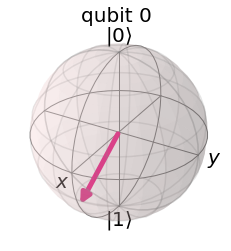

In [5]:
from qiskit.visualization import plot_bloch_multivector

# initial uknkown state
print("Initial unknown state =", unknown_state)
print()
plot_bloch_multivector(unknown_state)

Final state = Statevector([ 0.       +0.00000000e+00j,  0.5      +0.00000000e+00j,
              0.       +0.00000000e+00j, -0.       +0.00000000e+00j,
             -0.       +0.00000000e+00j,  0.8660254-1.06057524e-16j,
             -0.       +0.00000000e+00j, -0.       +0.00000000e+00j],
            dims=(2, 2, 2))



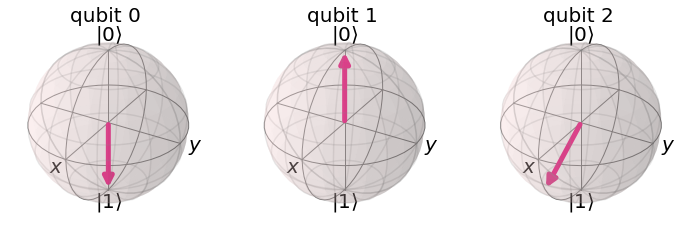

In [6]:
from qiskit.visualization import plot_bloch_multivector

# final state
print("Final state =", final_state)
print()
plot_bloch_multivector(final_state)

We see that the Alice's initial `uknown_state` is exactly the state of Bob's final qubit $\ket{q_2}$&mdash;the teleportation protocol worked!

Also, note that Alice's original initial state (in `qubit 0`) is lost in the final total state of the whole system. This confirms one cannot clone a quantum state. Both qubits in Alice's possession are either $\ket{0}$ or $\ket{1}$ as a result of measurement that Alice performed. The states of `qubit 0` and `qubit 1` show which bitstring was applied on Bob's side. 



> **Exercise 1**. In the above code, change the initial state to some random qubit state. Note that the state needs to be normalized. Run the code, plot the initial and final states to convince yourself that the teleportation protocol worked.

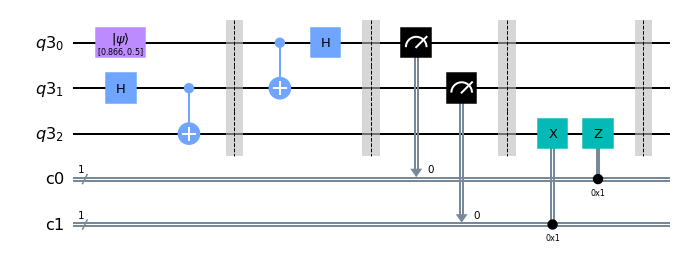

In [10]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np

# coefficients of uknown state Alice sends to Bob
unknown_state = [np.sqrt(3. / 4), np.sqrt(1. / 4)]

# create quantum circuit
q = QuantumRegister(3)

c0 = ClassicalRegister(1, name="c0")
c1 = ClassicalRegister(1, name="c1")

qc = QuantumCircuit(q, c0, c1)

qc.initialize(unknown_state, 0)

qc.h(1)                          # entangle Alice and Bob qubits
qc.cx(1, 2)                      #

qc.barrier()

qc.cx(0, 1)                      # Alice performs on her qubits
qc.h(0)

qc.barrier()

qc.measure(q[0], c0)             # Alice measures her qubits
qc.measure(q[1], c1)

qc.barrier()

# ctrl gates
qc.x(q[2]).c_if(c1, 1)
qc.z(q[2]).c_if(c0, 1)

# run
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = assemble(qc)
result = sim.run(qobj).result()  # run circuit, get results

# final state
final_state = result.get_statevector()

# draw the circuit
qc.draw("mpl")

Initial unknown state = [0.8660254037844386, 0.5]



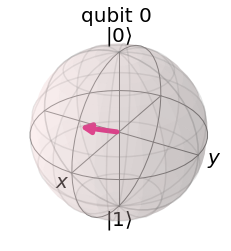

In [11]:
from qiskit.visualization import plot_bloch_multivector

# initial uknkown state
print("Initial unknown state =", unknown_state)
print()
plot_bloch_multivector(unknown_state)

Final state = Statevector([ 0.       +0.000000e+00j, -0.       +0.000000e+00j,
              0.8660254+0.000000e+00j,  0.       +0.000000e+00j,
              0.       +0.000000e+00j,  0.       +0.000000e+00j,
              0.5      -6.123234e-17j, -0.       +0.000000e+00j],
            dims=(2, 2, 2))



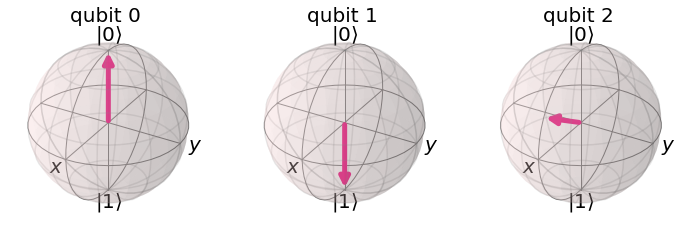

In [12]:
from qiskit.visualization import plot_bloch_multivector

# final state
print("Final state =", final_state)
print()
plot_bloch_multivector(final_state)

#### **Theoretical explanation**

Now that we have seen that quantum teleportation works in practice, let us discuss the theoretical explanation.


**Preparation**. Before starting the protocol, in 'Preparation: create shared entangled state' we created an entangled pair of particles in the Bell state 

$$
\ket{\beta_{00}} = \frac{\ket{00} + \ket{11}}{\sqrt{2}}
$$

where one particle is in Alice's and the other in Bob's possession. Alice also has another particle whose state $\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$ is not known to her, and whose state she wants to teleport. The total state of the system at the end of preparation is given by

\begin{align}
\ket{\Psi_1} &= \ket{\psi}\ket{\beta_{00}} \\
&= \frac{1}{\sqrt{2}}\left[ \alpha \ket{0} \left( \ket{00} + \ket{11} \right) + \beta \ket{1} \left( \ket{00} + \ket{11} \right) \right].
\end{align}


**Step 1**. As the first step of the teleportation protocol, we apply the CNOT gate where the control gate is Alice's particle in state $\ket{\psi}$. As a result, the total state is

$$
\ket{\Psi_2} = 
\frac{1}{\sqrt{2}}\left[ \alpha \ket{0} \left( \ket{00} + \ket{11} \right) + \beta \ket{1} \left( \ket{10} + \ket{01} \right) \right]
$$

Next we apply the Hadamard gate to the Alice's qubit in the unknown state. The state becomes

\begin{align}
\ket{\Psi_3} &= 
\frac{1}{\sqrt{2}}\left[ \alpha \left( \frac{\ket{0} + \ket{1}}{\sqrt{2}} \right) \left( \ket{00} + \ket{11} \right) + \beta \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right) \left( \ket{10} + \ket{01} \right) \right] 
\\
&= 
\frac{1}{2}\left[ \alpha \left( \ket{0} + \ket{1} \right) \left( \ket{00} + \ket{11} \right) + \beta \left( \ket{0} - \ket{1} \right) \left( \ket{10} + \ket{01} \right) \right] 
\end{align}

We can re-write this expression to better see the structure we are going to use in the next step. This does not change the state, we are just re-organizing it,

\begin{align}
\ket{\Psi_3} = 
\frac{1}{2} &\left[ \ket{00} \left( \alpha\ket{0} + \beta\ket{1} \right) + 
\ket{01} \left( \alpha\ket{1} + \beta\ket{0} \right) \right. \\
+&\left. \ket{10} \left( \alpha\ket{0} - \beta\ket{1} \right) + 
\ket{11} \left( \alpha\ket{1} - \beta\ket{0} \right) \right].
\end{align}


**Step 2**. Alice measures her two (leftmost) qubits, getting one of the four outcomes, $00, 01, 10$ or $11$. These correspond to the four states $\ket{00}, \ket{01}, \ket{10}$ or $\ket{11}$. As a result of the measurement, the total state $\ket{\Psi_3}$ will collapse to one of the following four cases: 

\begin{align}
00 &\rightarrow  \ket{\Psi_4} = \ket{00} \left( \alpha\ket{0} + \beta\ket{1} \right), \\
01 &\rightarrow  \ket{\Psi_4} = \ket{01} \left( \alpha\ket{1} + \beta\ket{0} \right), \\ 
10 &\rightarrow  \ket{\Psi_4} = \ket{10} \left( \alpha\ket{0} - \beta\ket{1} \right), \\
11 &\rightarrow  \ket{\Psi_4} = \ket{11} \left( \alpha\ket{1} - \beta\ket{0} \right).
\end{align}


**Step 3**. Alice will send the measurement result, the bitstring $\ket{00}, \ket{01}, \ket{10}$ or $\ket{11}$ to Bob, which helps Bob to post-process the state and bring it to the original state that Alice had at the beginning. The post-processing transformation is $Z^{m_0} X^{m_1}$ where $m_0$ and $m_1$ are Alice's measurement results of qubits $q0$ and $q1$.

For instance, suppose the measurement result was $m_0 = 0$ and $m_1 = 1$. Then the state in Bob's possession is $\alpha\ket{1} + \beta\ket{0}$ and he needs to apply transformation $X$

$$
X \left( \alpha\ket{1} + \beta\ket{0} \right) = \alpha\ket{0} + \beta\ket{1}
$$

getting the exact state that Alice had in the beginning. Try work out the other cases and convince yourself that the protocol works.